In [15]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
RESULTS_DIR = os.path.join(PROJECT_ROOT, "results")
DATA_DIR = os.path.join(PROJECT_ROOT, "data")

os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)


In [16]:
import simpy
import random
import numpy as np


In [17]:
def queue_simulation(arrival_rate, service_rate, servers, max_customers):
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=servers)
    wait_times = []

    def customer(env):
        arrive = env.now
        with server.request() as req:
            yield req
            wait_times.append(env.now - arrive)
            service_time = random.expovariate(1 / service_rate)
            yield env.timeout(service_time)

    def arrival_process(env):
        for _ in range(max_customers):
            env.process(customer(env))
            yield env.timeout(random.expovariate(1 / arrival_rate))

    env.process(arrival_process(env))
    env.run()
    return np.mean(wait_times)


In [18]:
data = []

for _ in range(1000):
    arrival_rate = random.uniform(1, 5)
    service_rate = random.uniform(1, 6)
    servers = random.randint(1, 5)
    max_customers = random.randint(50, 200)

    avg_wait = queue_simulation(
        arrival_rate, service_rate, servers, max_customers
    )

    data.append([
        arrival_rate,
        service_rate,
        servers,
        max_customers,
        avg_wait
    ])

df = pd.DataFrame(data, columns=[
    "arrival_rate",
    "service_rate",
    "servers",
    "max_customers",
    "avg_wait_time"
])

df.to_csv(os.path.join(DATA_DIR, "simpy_dataset.csv"), index=False)
df.head()


,arrival_rate,service_rate,servers,max_customers,avg_wait_time
0,4.071029,1.392424,1,117,1.138130
1,4.765311,1.015528,4,187,0.000000
2,3.746676,5.087276,2,51,0.442980
3,1.447656,5.793262,2,171,120.806121
4,2.204349,4.120533,2,144,16.589151


In [19]:
df.describe()


,arrival_rate,service_rate,servers,max_customers,avg_wait_time
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.989809,3.523742,3.055000,126.486000,16.109045
std,1.152941,1.427539,1.421265,42.894192,48.387428
min,1.001730,1.008471,1.000000,50.000000,0.000000
25%,1.989042,2.275100,2.000000,91.000000,0.006346
50%,3.022534,3.515968,3.000000,127.000000,0.245724
75%,4.000971,4.727239,4.000000,163.000000,4.024491
max,4.997629,5.998550,5.000000,200.000000,379.671762


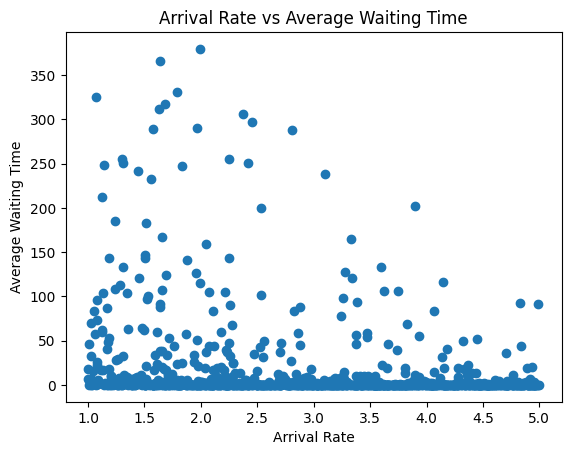

In [20]:
plt.figure()
plt.scatter(df["arrival_rate"], df["avg_wait_time"])
plt.xlabel("Arrival Rate")
plt.ylabel("Average Waiting Time")
plt.title("Arrival Rate vs Average Waiting Time")

plt.savefig(os.path.join(RESULTS_DIR, "arrival_vs_wait.png"), bbox_inches="tight")
plt.show()


In [21]:
from sklearn.model_selection import train_test_split

X = df.drop("avg_wait_time", axis=1)
y = df["avg_wait_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)


In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [23]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor()
}


In [24]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    results.append([
        name,
        mean_squared_error(y_test, preds),
        mean_absolute_error(y_test, preds),
        r2_score(y_test, preds)
    ])

results_df = pd.DataFrame(
    results, columns=["Model", "MSE", "MAE", "R2"]
)

RESULTS_PATH = os.path.join(PROJECT_ROOT, "results", "model_comparison.csv")
results_df.to_csv(RESULTS_PATH, index=False)

results_df


,Model,MSE,MAE,R2
0,Linear,1570.578866,24.564569,0.326237
1,Ridge,1570.560604,24.557540,0.326244
2,Lasso,1570.991111,24.104948,0.326060
3,KNN,1591.070076,14.995151,0.317446
4,SVR,2573.087980,15.959420,-0.103830
5,Decision Tree,275.753149,5.600421,0.881705
6,Random Forest,173.944678,4.921028,0.925379
7,Gradient Boosting,274.495019,7.360543,0.882244


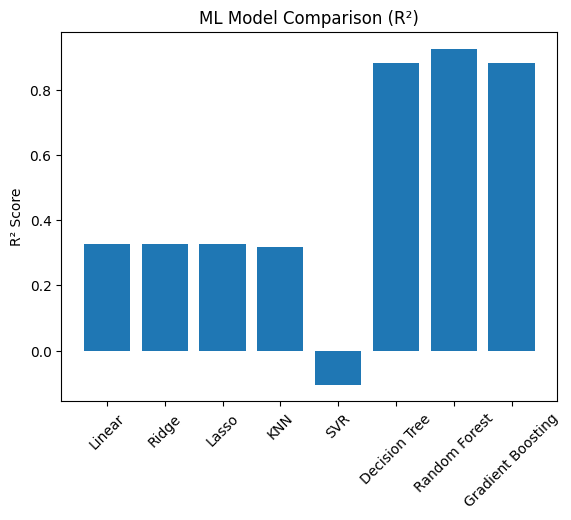

In [25]:
plt.figure()
plt.bar(results_df["Model"], results_df["R2"])
plt.xticks(rotation=45)
plt.ylabel("R² Score")
plt.title("ML Model Comparison (R²)")

plt.savefig(os.path.join(RESULTS_DIR, "model_r2_comparison.png"), bbox_inches="tight")
plt.show()


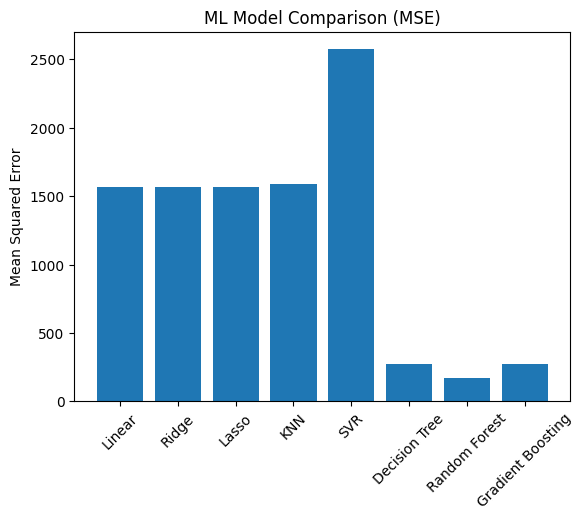

In [26]:
plt.figure()
plt.bar(results_df["Model"], results_df["MSE"])
plt.xticks(rotation=45)
plt.ylabel("Mean Squared Error")
plt.title("ML Model Comparison (MSE)")

plt.savefig(os.path.join(RESULTS_DIR, "model_mse_comparison.png"), bbox_inches="tight")
plt.show()


In [28]:
criteria = results_df[["MSE", "MAE", "R2"]].values
norm = criteria / np.sqrt((criteria**2).sum(axis=0))

weights = np.array([0.33, 0.33, 0.34])
weighted = norm * weights

ideal_best = [
    weighted[:, 0].min(),
    weighted[:, 1].min(),
    weighted[:, 2].max()
]

ideal_worst = [
    weighted[:, 0].max(),
    weighted[:, 1].max(),
    weighted[:, 2].min()
]

dist_best = np.linalg.norm(weighted - ideal_best, axis=1)
dist_worst = np.linalg.norm(weighted - ideal_worst, axis=1)

results_df["TOPSIS Score"] = dist_worst / (dist_best + dist_worst)
results_df["Rank"] = results_df["TOPSIS Score"].rank(ascending=False)

TOPSIS_PATH = os.path.join(PROJECT_ROOT, "results", "topsis_ranking.csv")
results_df.to_csv(TOPSIS_PATH, index=False)

results_df.sort_values("Rank")


,Model,MSE,MAE,R2,TOPSIS Score,Rank
6,Random Forest,173.944678,4.921028,0.925379,1.000000,1.0
5,Decision Tree,275.753149,5.600421,0.881705,0.958872,2.0
7,Gradient Boosting,274.495019,7.360543,0.882244,0.935626,3.0
3,KNN,1591.070076,14.995151,0.317446,0.423611,4.0
2,Lasso,1570.991111,24.104948,0.326060,0.360692,5.0
1,Ridge,1570.560604,24.557540,0.326244,0.358675,6.0
0,Linear,1570.578866,24.564569,0.326237,0.358636,7.0
4,SVR,2573.087980,15.959420,-0.103830,0.165617,8.0


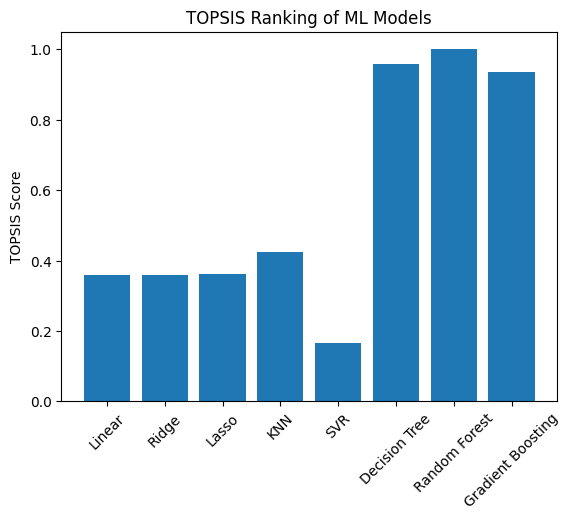

In [29]:
plt.figure()
plt.bar(results_df["Model"], results_df["TOPSIS Score"])
plt.xticks(rotation=45)
plt.ylabel("TOPSIS Score")
plt.title("TOPSIS Ranking of ML Models")

plt.savefig(os.path.join(RESULTS_DIR, "topsis_ranking.png"), bbox_inches="tight")
plt.show()


In [30]:
best_model = results_df.sort_values("Rank").iloc[0]
best_model


Model           Random Forest
MSE                173.944678
MAE                  4.921028
R2                   0.925379
TOPSIS Score              1.0
Rank                      1.0
Name: 6, dtype: object